  TOWNID  TOWNCODE COUNTYNAME TOWNNAME             TOWNENG COUNTYID  \
0    V02  10014020        臺東縣      成功鎮  Chenggong Township        V   
1    T21  10013210        屏東縣      佳冬鄉    Jiadong Township        T   
2    P13  10009130        雲林縣      麥寮鄉    Mailiao Township        P   
3    V11  10014110        臺東縣      綠島鄉      Lüdao Township        V   
4    V16  10014160        臺東縣      蘭嶼鄉      Lanyu Township        V   

  COUNTYCODE                                           geometry  
0      10014  POLYGON ((121.36149 23.22900, 121.36219 23.228...  
1      10013  POLYGON ((120.54845 22.46067, 120.54853 22.460...  
2      10009  POLYGON ((120.30198 23.81624, 120.30198 23.815...  
3      10014  MULTIPOLYGON (((121.49154 22.67746, 121.49184 ...  
4      10014  MULTIPOLYGON (((121.61179 21.94290, 121.61133 ...  
     鄉鎮市區       交易標的             土地區段位置建物區段門牌  土地移轉總面積平方公尺 都市土地使用分區  \
0     中和區  房地(土地+建物)  新北市中和區興南路一段１０５巷２０弄１７號三樓        12.87        住   
1     中和區  房地(土地+建物)       新北市中和區國光

C:\Users\chibisakura\AppData\Local\Temp\ipykernel_4816\1560707075.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mrt_distance = gdf_real_estate.groupby('距離分類')


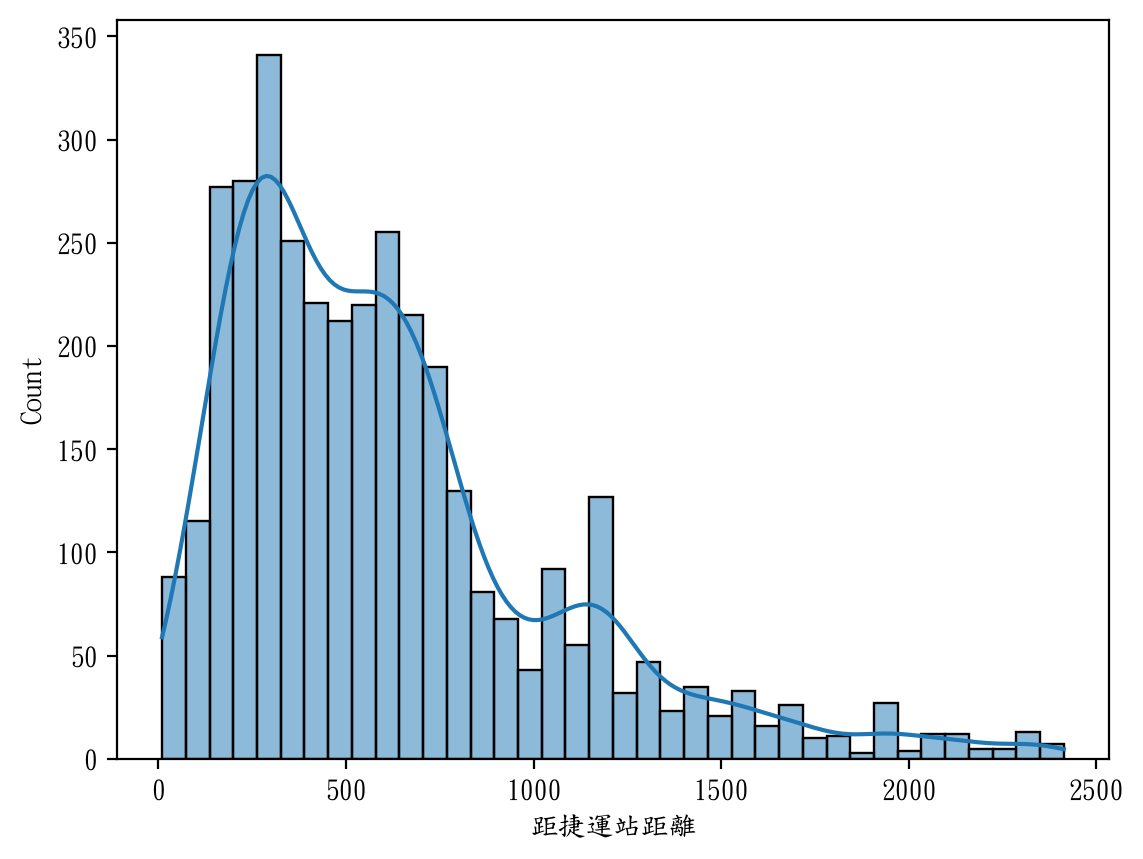

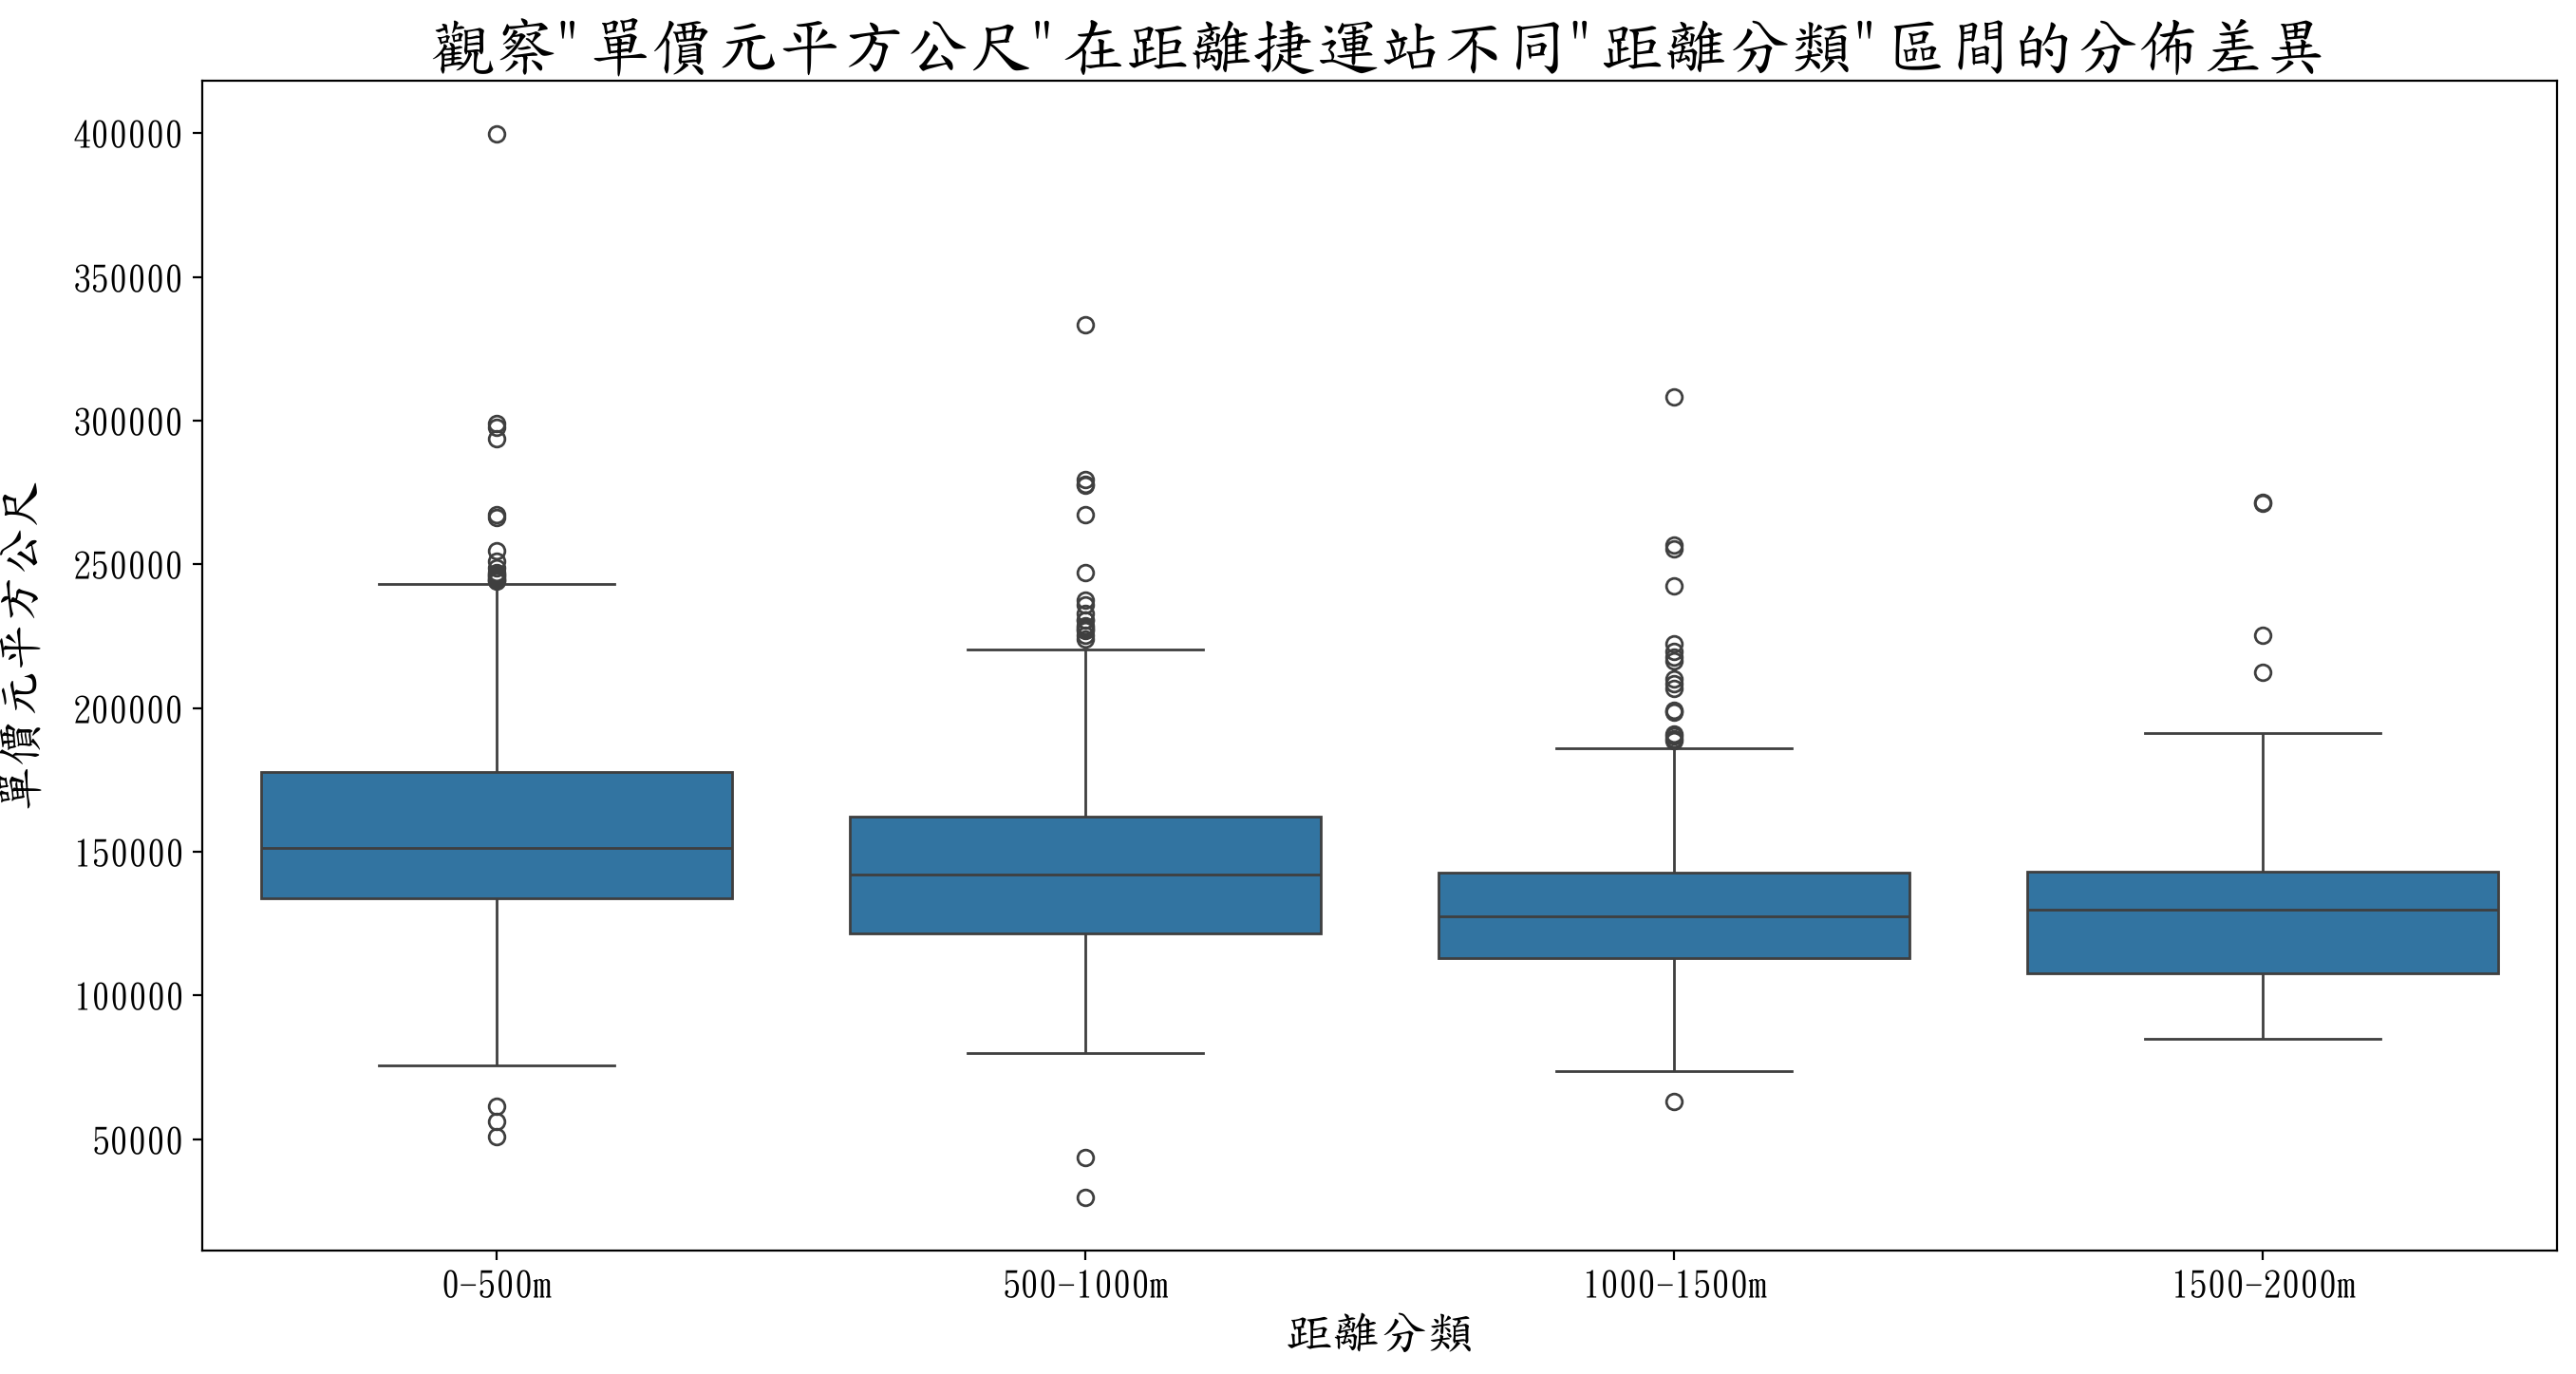

In [2]:
import geopandas as gpd
import pandas as pd

# 讀取中和區範圍的shp
county_data = gpd.read_file('./圖像資料/鄉(鎮、市、區)界線(TWD97經緯度)1140318/TOWN_MOI_1140318.shp')
print(county_data.head())
Zhonghe_District_data = county_data[county_data['TOWNNAME'] == '中和區']

# 將房屋轉成GeoDataFrame
df = pd.read_csv('./data/real_estate_cleaned.csv', encoding = 'utf-8')

gdf_real_estate = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df['Lng'], df['Lat']), crs = 'EPSG: 4326')
gdf_real_estate = gdf_real_estate.to_crs(Zhonghe_District_data.crs)

# 判斷是否位於中和區
gdf_real_estate['in_Zhonghe'] = gdf_real_estate.within(Zhonghe_District_data.geometry.iloc[0])
print(gdf_real_estate)

filter = (gdf_real_estate['in_Zhonghe'] == False)
print(gdf_real_estate[filter])

# 計算距離最近捷運站的距離(先轉成平面座標)

gdf_real_estate = gdf_real_estate.to_crs(epsg = 3826)

df_mrt = pd.read_csv('./data/northern-taiwan-mrt-station.csv', encoding = 'utf-8')
gdf_mrt = gpd.GeoDataFrame(df_mrt, geometry = gpd.points_from_xy(df_mrt['lon'], df_mrt['lat']), crs = 'EPSG: 4326')
gdf_mrt = gdf_mrt.to_crs(epsg = 3826)
Zhonghe_gdf_mrt1 = gdf_mrt[gdf_mrt['address'].str.contains('新北市中和區', na = False)]

# 去除'景安'站的重複值
Zhonghe_gdf_mrt = Zhonghe_gdf_mrt1.drop_duplicates(subset = ['station_name_tw'])

print(Zhonghe_gdf_mrt)
print(Zhonghe_gdf_mrt.shape)

gdf_real_estate['距捷運站距離'] = gdf_real_estate.geometry.apply(lambda p: Zhonghe_gdf_mrt.distance(p).min())

gdf_real_estate['距離分類'] = pd.cut(gdf_real_estate['距捷運站距離'],
                                bins = [0, 500, 1000, 1500, 2000],
                                labels = ['0-500m', '500-1000m', '1000-1500m', '1500-2000m'])
print(gdf_real_estate)

# 統計各種不同距離的房屋數量
mrt_distance = gdf_real_estate.groupby('距離分類')
print(mrt_distance.size())

# 算出各種不同距離的房屋均價
print(mrt_distance['單價元平方公尺'].mean())

# 將圖表改為標楷體
import matplotlib
matplotlib.rc('font', family = 'DFKai-SB')

# 提高jupyter notebook圖形顥示解析度
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import matplotlib.pyplot as plt

# 繪出'距捷運站距離'直方圖
sns.histplot(gdf_real_estate['距捷運站距離'], kde = True)
plt.show()

# 用boxplot觀察'單價元平方公尺'在不同'距離分類'區間的分佈差異
a = gdf_real_estate.sort_values(by = '距離分類', ascending = True)
ax = sns.boxplot(x = '距離分類', y = '單價元平方公尺', data = a)
plt.xlabel('距離分類', fontsize = 18)
plt.ylabel('單價元平方公尺', fontsize = 18)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.figure.set_size_inches(16, 8)
plt.title('觀察"單價元平方公尺"在距離捷運站不同"距離分類"區間的分佈差異', fontsize = 24)
plt.show()
